<a href="https://colab.research.google.com/github/aralbright/2021_AAMSME/blob/main/scVI_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch correction and Visualization
Input: adata_b4batchcorrect.h5ad

- this anndata object contains already pre-processed and filtered nuclei from 'Preprocessing.ipynb' 

Output: adata_corrected.h5ad

- this anndata object will be used in the 'Differential_Expression.ipynb' and 'novosparc.ipynb' notebooks

**Bear in mind that each time scVI and visualizations are run, the plots may change**

## Download and import packages

In [21]:
!pip install anndata
!pip install scanpy
!pip install scvi-tools
!pip install leidenalg
!pip install color_tol

     |████████████████████████████████| 1.4 MB 8.0 MB/s 
     |████████████████████████████████| 3.2 MB 41.1 MB/s 


In [2]:
# Setup

import anndata
from anndata import AnnData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc
import scvi

from collections import OrderedDict
from sklearn.preprocessing import normalize

from color_tol import qualitative

import warnings
warnings.filterwarnings('ignore')

# matplotlib settings

fsize=20
plt.rcParams.update({'font.size': fsize, 'axes.grid':False})
%config InlineBackend.figure_format = 'retina'

# scanpy settings 

sc.set_figure_params(dpi_save = 400, fontsize = 20)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


### Load and setup adata

In [3]:
!gdown --id 1NAw9kIuBawxY7NC2As7S6Cs6dPy90djp -O adata_b4batchcorrect.h5ad

Downloading...
From: https://drive.google.com/uc?id=1NAw9kIuBawxY7NC2As7S6Cs6dPy90djp
To: /content/adata_b4batchcorrect.h5ad
189MB [00:01, 142MB/s]


In [4]:
# Load AnnData

adata = anndata.read_h5ad("adata_b4batchcorrect.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 14973 × 12366
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1'

In [6]:
# create a layer containing the raw data
adata.layers["raw"] = adata.X

# this is what scvi eventually takes as input
adata.raw = adata

Scaling, normalizing, and logarithmizing data isn't technically necessary for scvi; instead, I've done so because I'm subsetting the adata based on the top 6000 highly variable genes prior to running scvi. 

In [7]:
## normalize 
scale_num = 10000
adata.layers["norm"] = normalize(adata.X, norm="l1", axis=1)*scale_num

## log1p 
adata.layers["log1p"] = np.log1p(adata.layers["norm"])
adata.uns = OrderedDict([("log1p", {"base":None})])
adata.X = adata.layers["log1p"]

In [8]:
# parameters used to find highly variable genes
n_top_genes = 6000
n_bins = 20
flavor="seurat"

In [9]:
# subset = True subsets the data based on the highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins, subset = True)

In [10]:
# this probably isn't necessary because I set layer = raw in the next cell, but just in case... 
adata.X = adata.layers['raw']

In [11]:
# setting up anndata for scvi model
scvi.data.setup_anndata(adata, batch_key ='batch', layer='raw')

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["raw"]                                                 
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 14973 cells, 6000 vars, 2 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


## Run scVI and save model 

In [12]:
model = scvi.model.SCVI(adata, gene_likelihood = 'nb')

In [13]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [14]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 400/400: 100%|██████████| 400/400 [2:19:58<00:00, 21.00s/it, loss=1.87e+03, v_num=1]


In [15]:
# save model
model.save("scvi_model")

## Visualization


In [16]:
# Load model 
model = scvi.model.SCVI.load(dir_path = "scvi_model", adata = adata)

INFO     Using data from adata.layers["raw"]                                                 
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 14973 cells, 6000 vars, 2 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [17]:
# Get latent representtion and normalized expression from scVI 
adata.obsm['X_scvi'] = model.get_latent_representation(adata)
adata.layers['X_scvi_norm'] = model.get_normalized_expression(adata, library_size = 1e4)
adata.layers['X_scvi_raw'] = model.get_normalized_expression(library_size = "latent")

In [18]:
# log1p scvi normalized expression
adata.layers['scvi_norm_log'] = np.log1p(adata.layers['X_scvi_norm'])

# save an unscaled log layer
adata.layers['norm_log_unscaled'] = adata.layers['scvi_norm_log']

# set layer to scvi_norm_log prior to scaling and clustering
adata.X = adata.layers["scvi_norm_log"]

In [19]:
# scale expression
sc.pp.scale(adata, max_value = 10)

In [22]:
# Cluster the nuclei 
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True, n_comps=10)

# make sure to use the scvi latent space here 
sc.pp.neighbors(adata, use_rep = 'X_scvi')

# and leiden_scvi here 
sc.tl.leiden(adata, key_added = 'leiden_scVI', resolution = 0.5)

In [23]:
# embed the neighborhood graph using UMAP 
sc.tl.umap(adata, min_dist = 0.3)

In [32]:
# get colorblind friendly colors
my_map = qualitative(12)
my_map.html_colors

['#332288',
 '#6699CC',
 '#88CCEE',
 '#44AA99',
 '#117733',
 '#999933',
 '#DDCC77',
 '#661100',
 '#CC6677',
 '#AA4466',
 '#882255',
 '#AA4499']

In [50]:
my_palette = list(my_map.html_colors)
my_palette.append('orange')

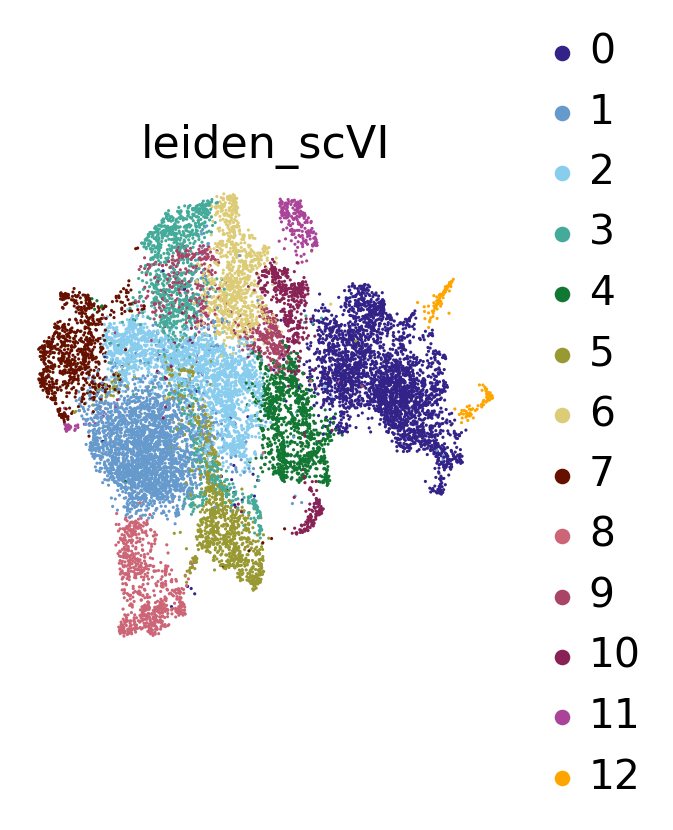

In [51]:
# plot UMAP by leiden
sc.pl.umap(adata, 
           color=['leiden_scVI'], 
           use_raw=False, 
           frameon=False, 
           palette = my_palette,
           save = 'leiden_scVI.png')

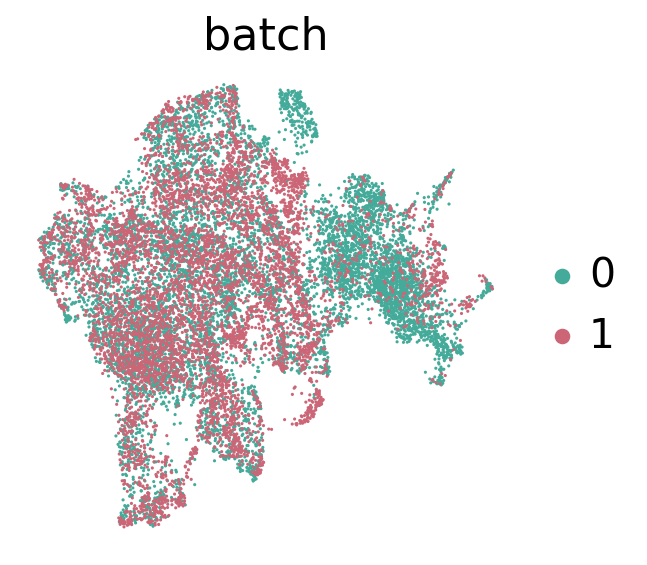

In [36]:
# plot UMAP by batch 
sc.pl.umap(adata, 
           color=['batch'], 
           use_raw=False, 
           frameon=False, 
           palette = ['#44AA99', '#CC6677'],
           save = 'umap_batch.png')

In [37]:
# set .X back to norm_log_unscaled to visualize expression of a few genes
adata.X = adata.layers['norm_log_unscaled']

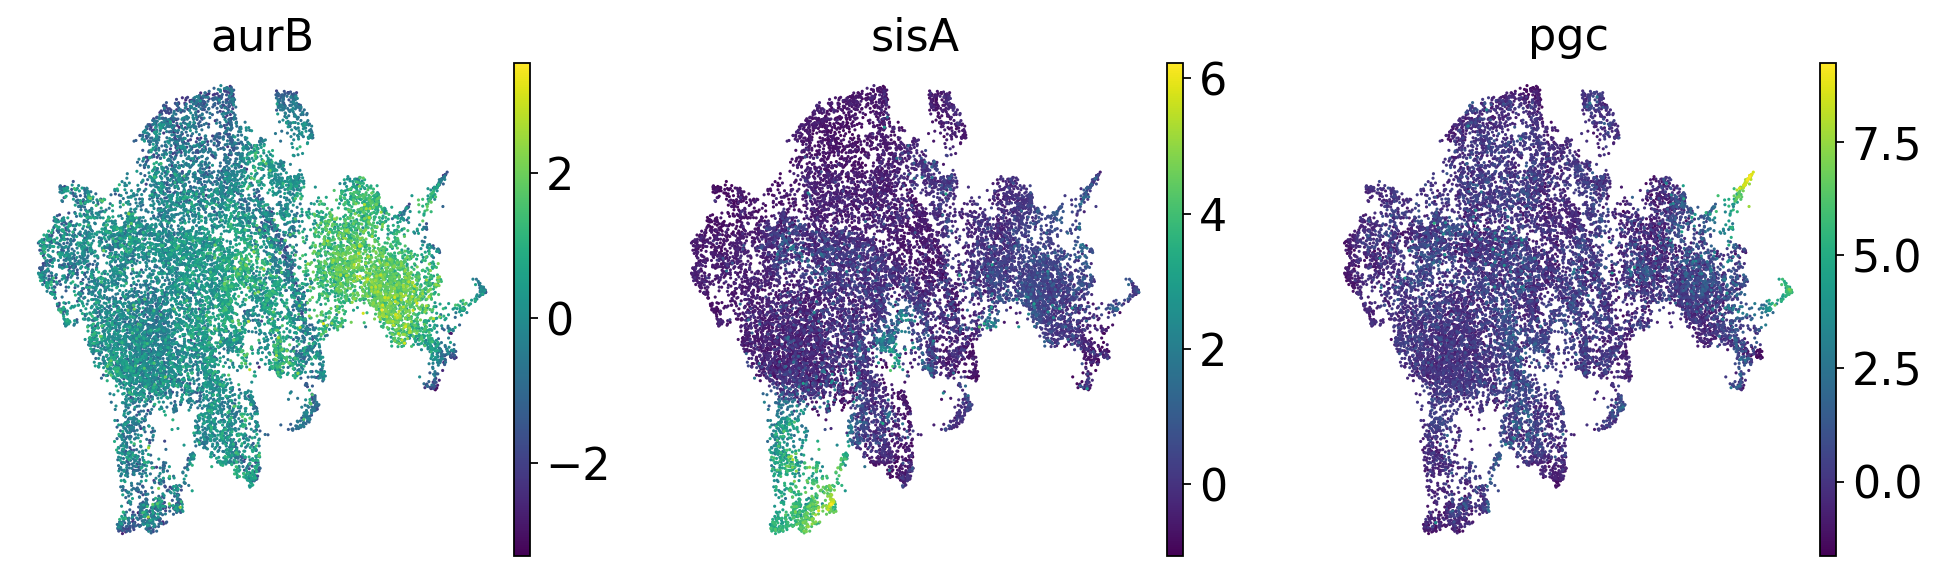

In [38]:
# plot UMAP by expression of aurB (cell cycle), sisA (yolk), and pgc (pole cell)
# will get rid of these later 
sc.pl.umap(adata, 
           color=["aurB", "sisA", "pgc"],
           use_raw = False, 
           frameon=False,
           save = '1_badgenes.png')

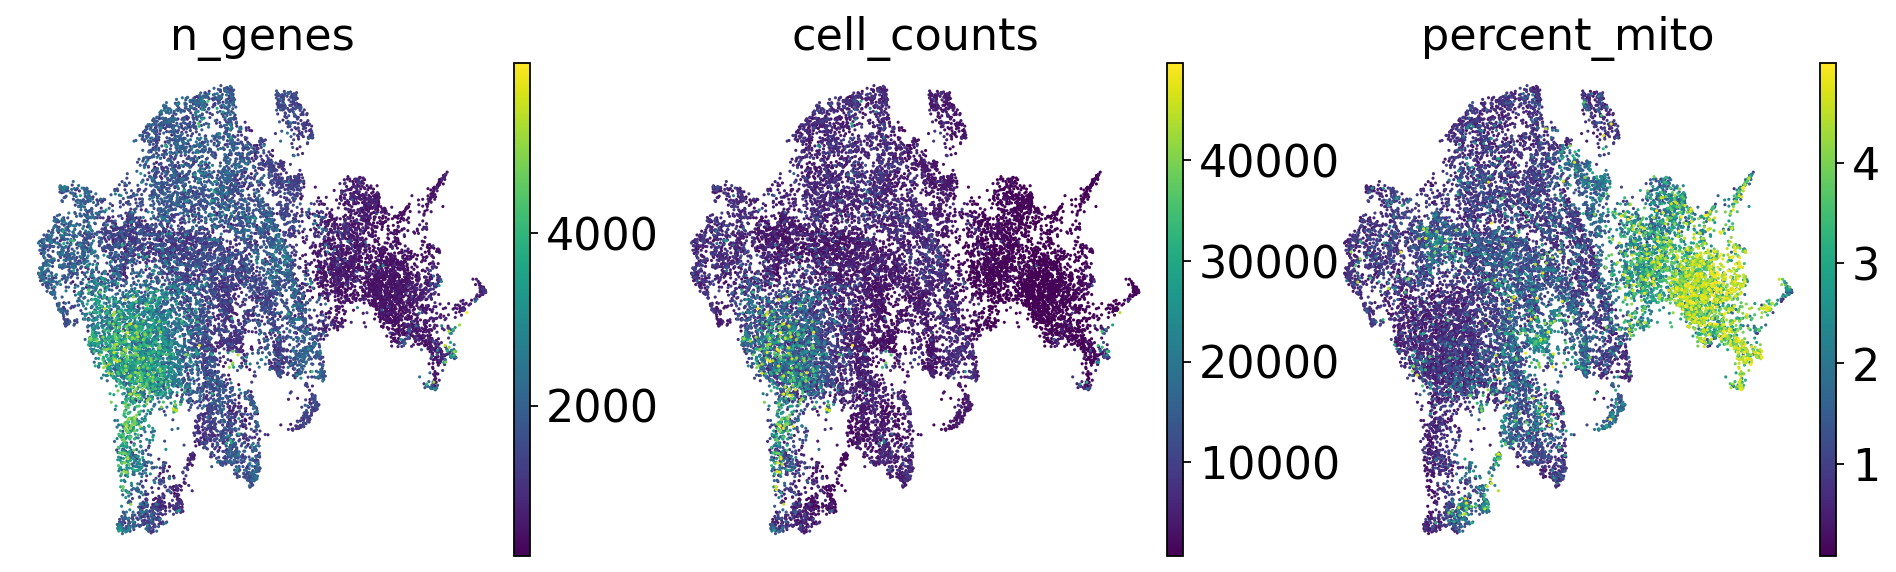

In [39]:
# plot UMAP by quality control metrics 
sc.pl.umap(adata, 
           color=["n_genes", "cell_counts", "percent_mito"],
           use_raw = False, 
           frameon=False,
           save = '1_QC.png')

## Remove cell cycle, yolk, and pole cell nuclei then re-cluster

In [52]:
# remove cell cycle, yolk, pole cell, high n_genes nuclei... make sure the numbers are right! 
remove_clusters = ['0', '12', '8', '1']
adata = adata[~adata.obs.leiden_scVI.isin(remove_clusters)]

In [53]:
# re-cluster with bad nuclei removed 
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True, n_comps=10)
sc.pp.neighbors(adata, use_rep = 'X_scvi')
sc.tl.leiden(adata, key_added = 'leiden_scVI', resolution = 0.5)

In [54]:
# embed the new neighborhood graph with UMAP
sc.tl.umap(adata, min_dist = 0.3)

In [55]:
# get colorblind friendly colors
my_map2 = qualitative(10)

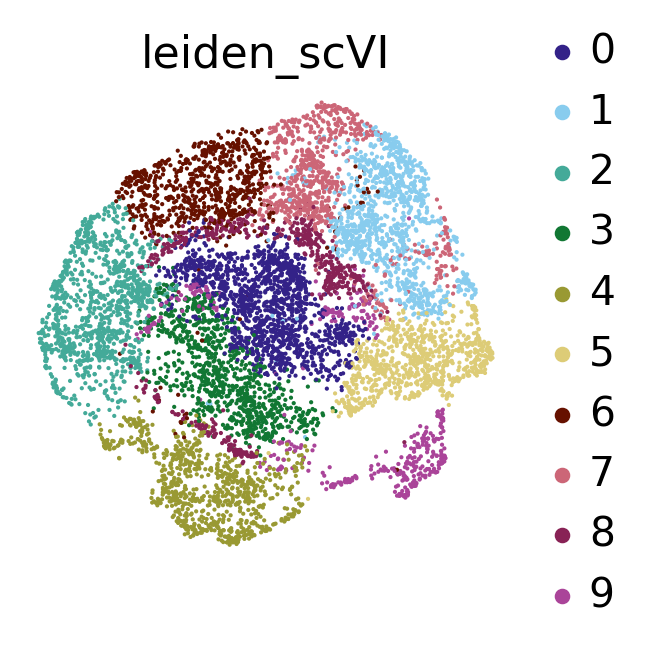

In [56]:
# plot UMAP by leiden
sc.pl.umap(adata, 
           color=['leiden_scVI'], 
           use_raw=False, 
           frameon=False,
           palette = my_map2.html_colors)
           #save = '1_leiden_scVI_after_filter.png')

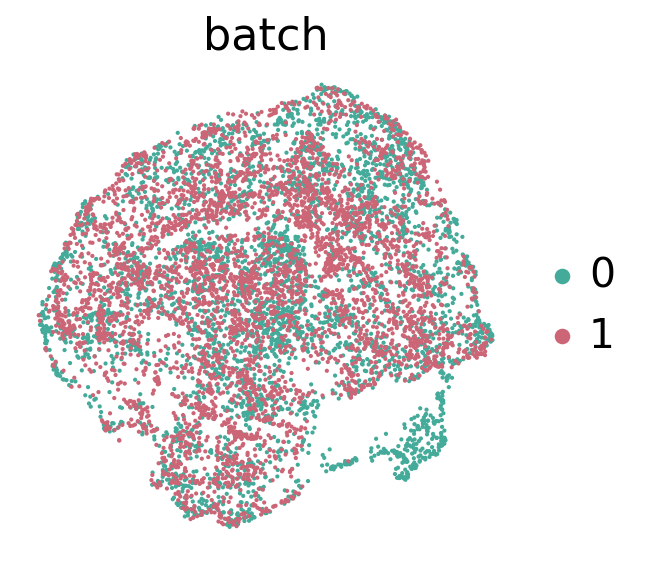

In [57]:
# plot UMAP by batch
sc.pl.umap(adata, 
           color=['batch'], 
           use_raw=False, 
           frameon=False,
           palette = ['#44AA99', '#CC6677'])
           #save = '1_umap_batch_after_filter.png')

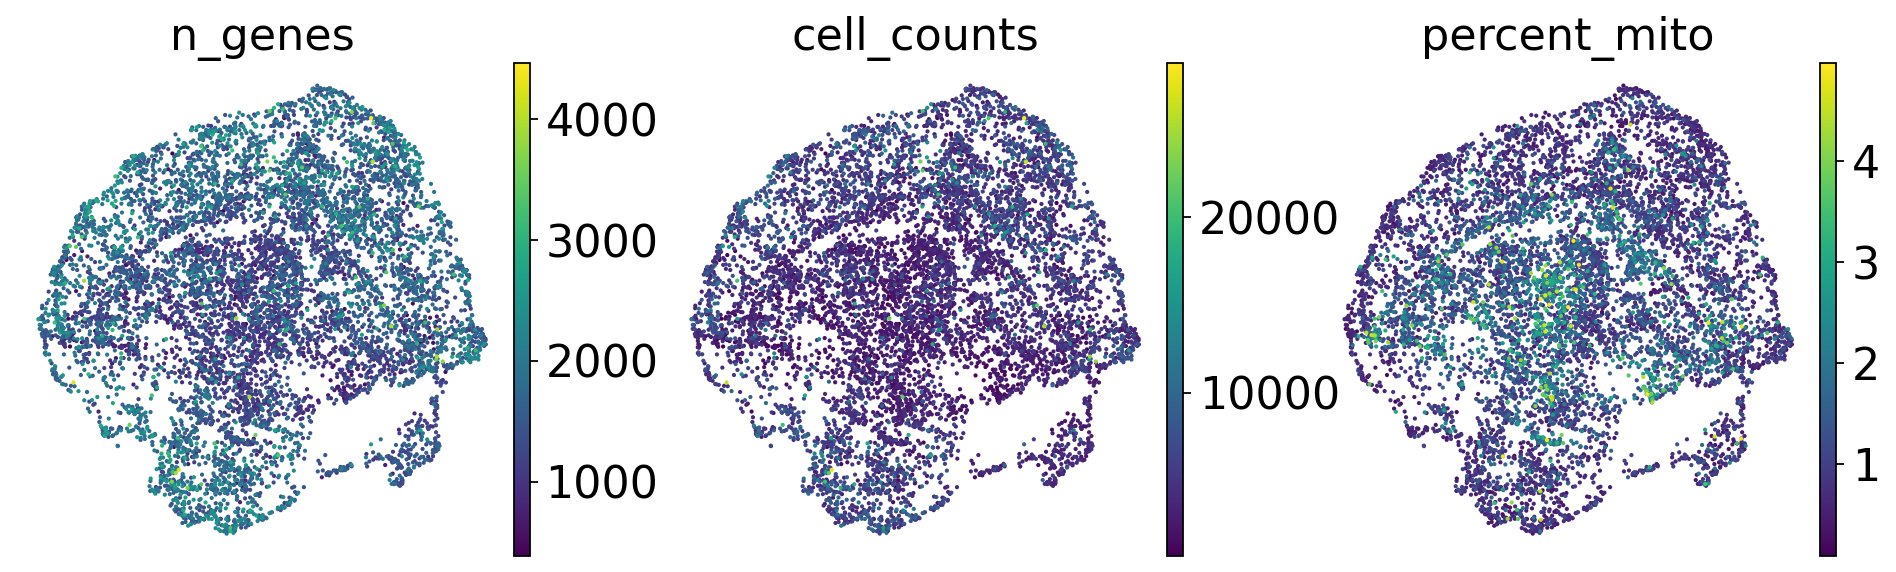

In [58]:
# plot UMAP by quality control
sc.pl.umap(adata, 
           color=["n_genes", "cell_counts", "percent_mito"], 
           use_raw = False, 
           frameon=False)
           #save = '1_umap_QC_after_filter.png')

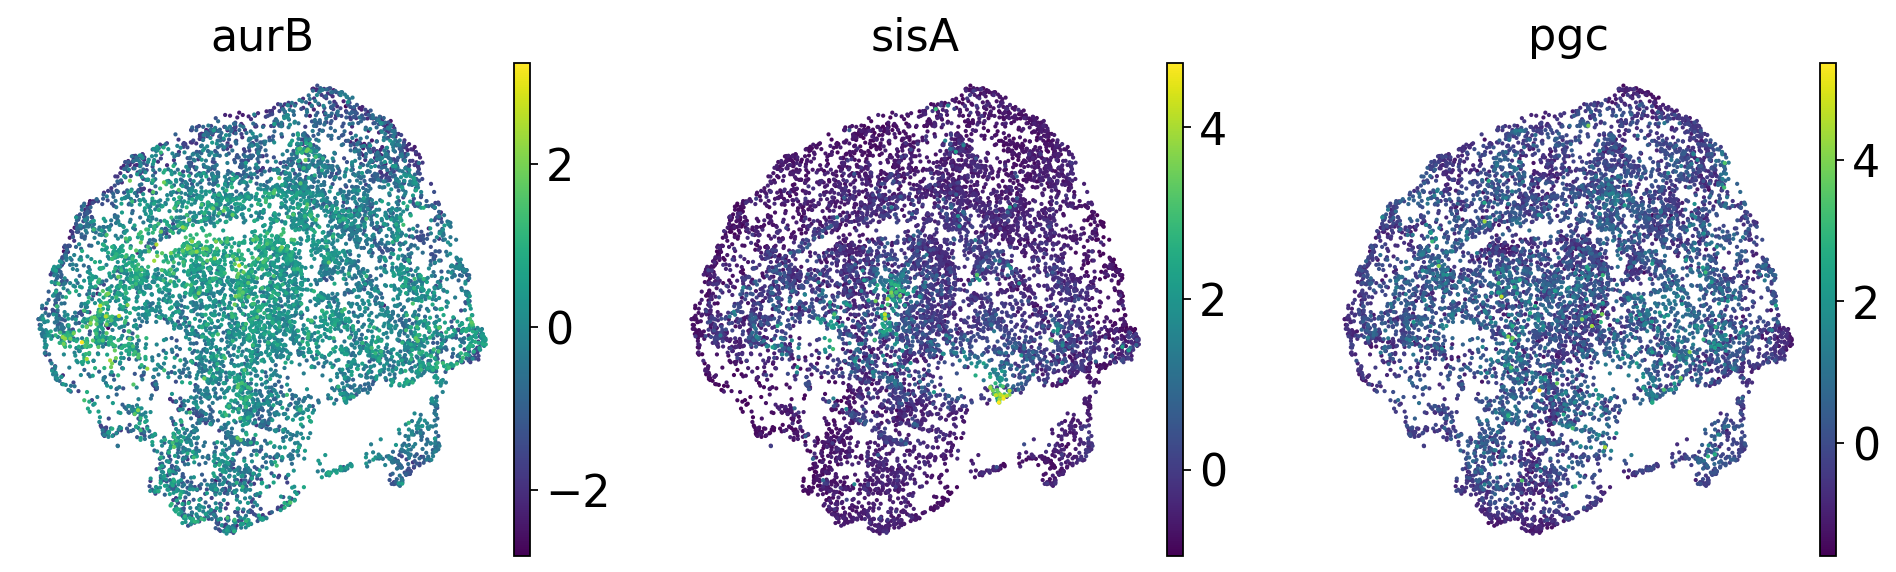

In [59]:
# plot UMAP by expression of aurB (cell cycle), sisA (yolk), and pgc (pole cell)
sc.pl.umap(adata, 
           color=["aurB", "sisA", "pgc"], 
           use_raw=False, 
           frameon=False) 
           #save = '1_umap_badgenes_after_filter.png')

In [60]:
adata

AnnData object with n_obs × n_vars = 8400 × 6000
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', '_scvi', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_scVI_colors', 'batch_colors'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'norm', 'log1p', 'X_scvi_norm', 'X_scvi_raw', 'scvi_norm_log', 'norm_log_unscaled'
    obsp: 'distances', 'connectivities'

In [65]:
# adata.write doesn't like _scvi in uns for whatever reason 

adata.uns.pop('_scvi')

{'categorical_mappings': {'_scvi_batch': {'mapping': array(['0', '1'], dtype=object),
   'original_key': 'batch'},
  '_scvi_labels': {'mapping': array([0]), 'original_key': '_scvi_labels'}},
 'data_registry': {'X': {'attr_key': 'raw', 'attr_name': 'layers'},
  'batch_indices': {'attr_key': '_scvi_batch', 'attr_name': 'obs'},
  'labels': {'attr_key': '_scvi_labels', 'attr_name': 'obs'},
  'local_l_mean': {'attr_key': '_scvi_local_l_mean', 'attr_name': 'obs'},
  'local_l_var': {'attr_key': '_scvi_local_l_var', 'attr_name': 'obs'}},
 'scvi_version': '0.12.0',
 'summary_stats': {'n_batch': 2,
  'n_cells': 14973,
  'n_continuous_covs': 0,
  'n_labels': 1,
  'n_proteins': 0,
  'n_vars': 6000}}

In [66]:
# save adata
adata.write('adata_corrected.h5ad')

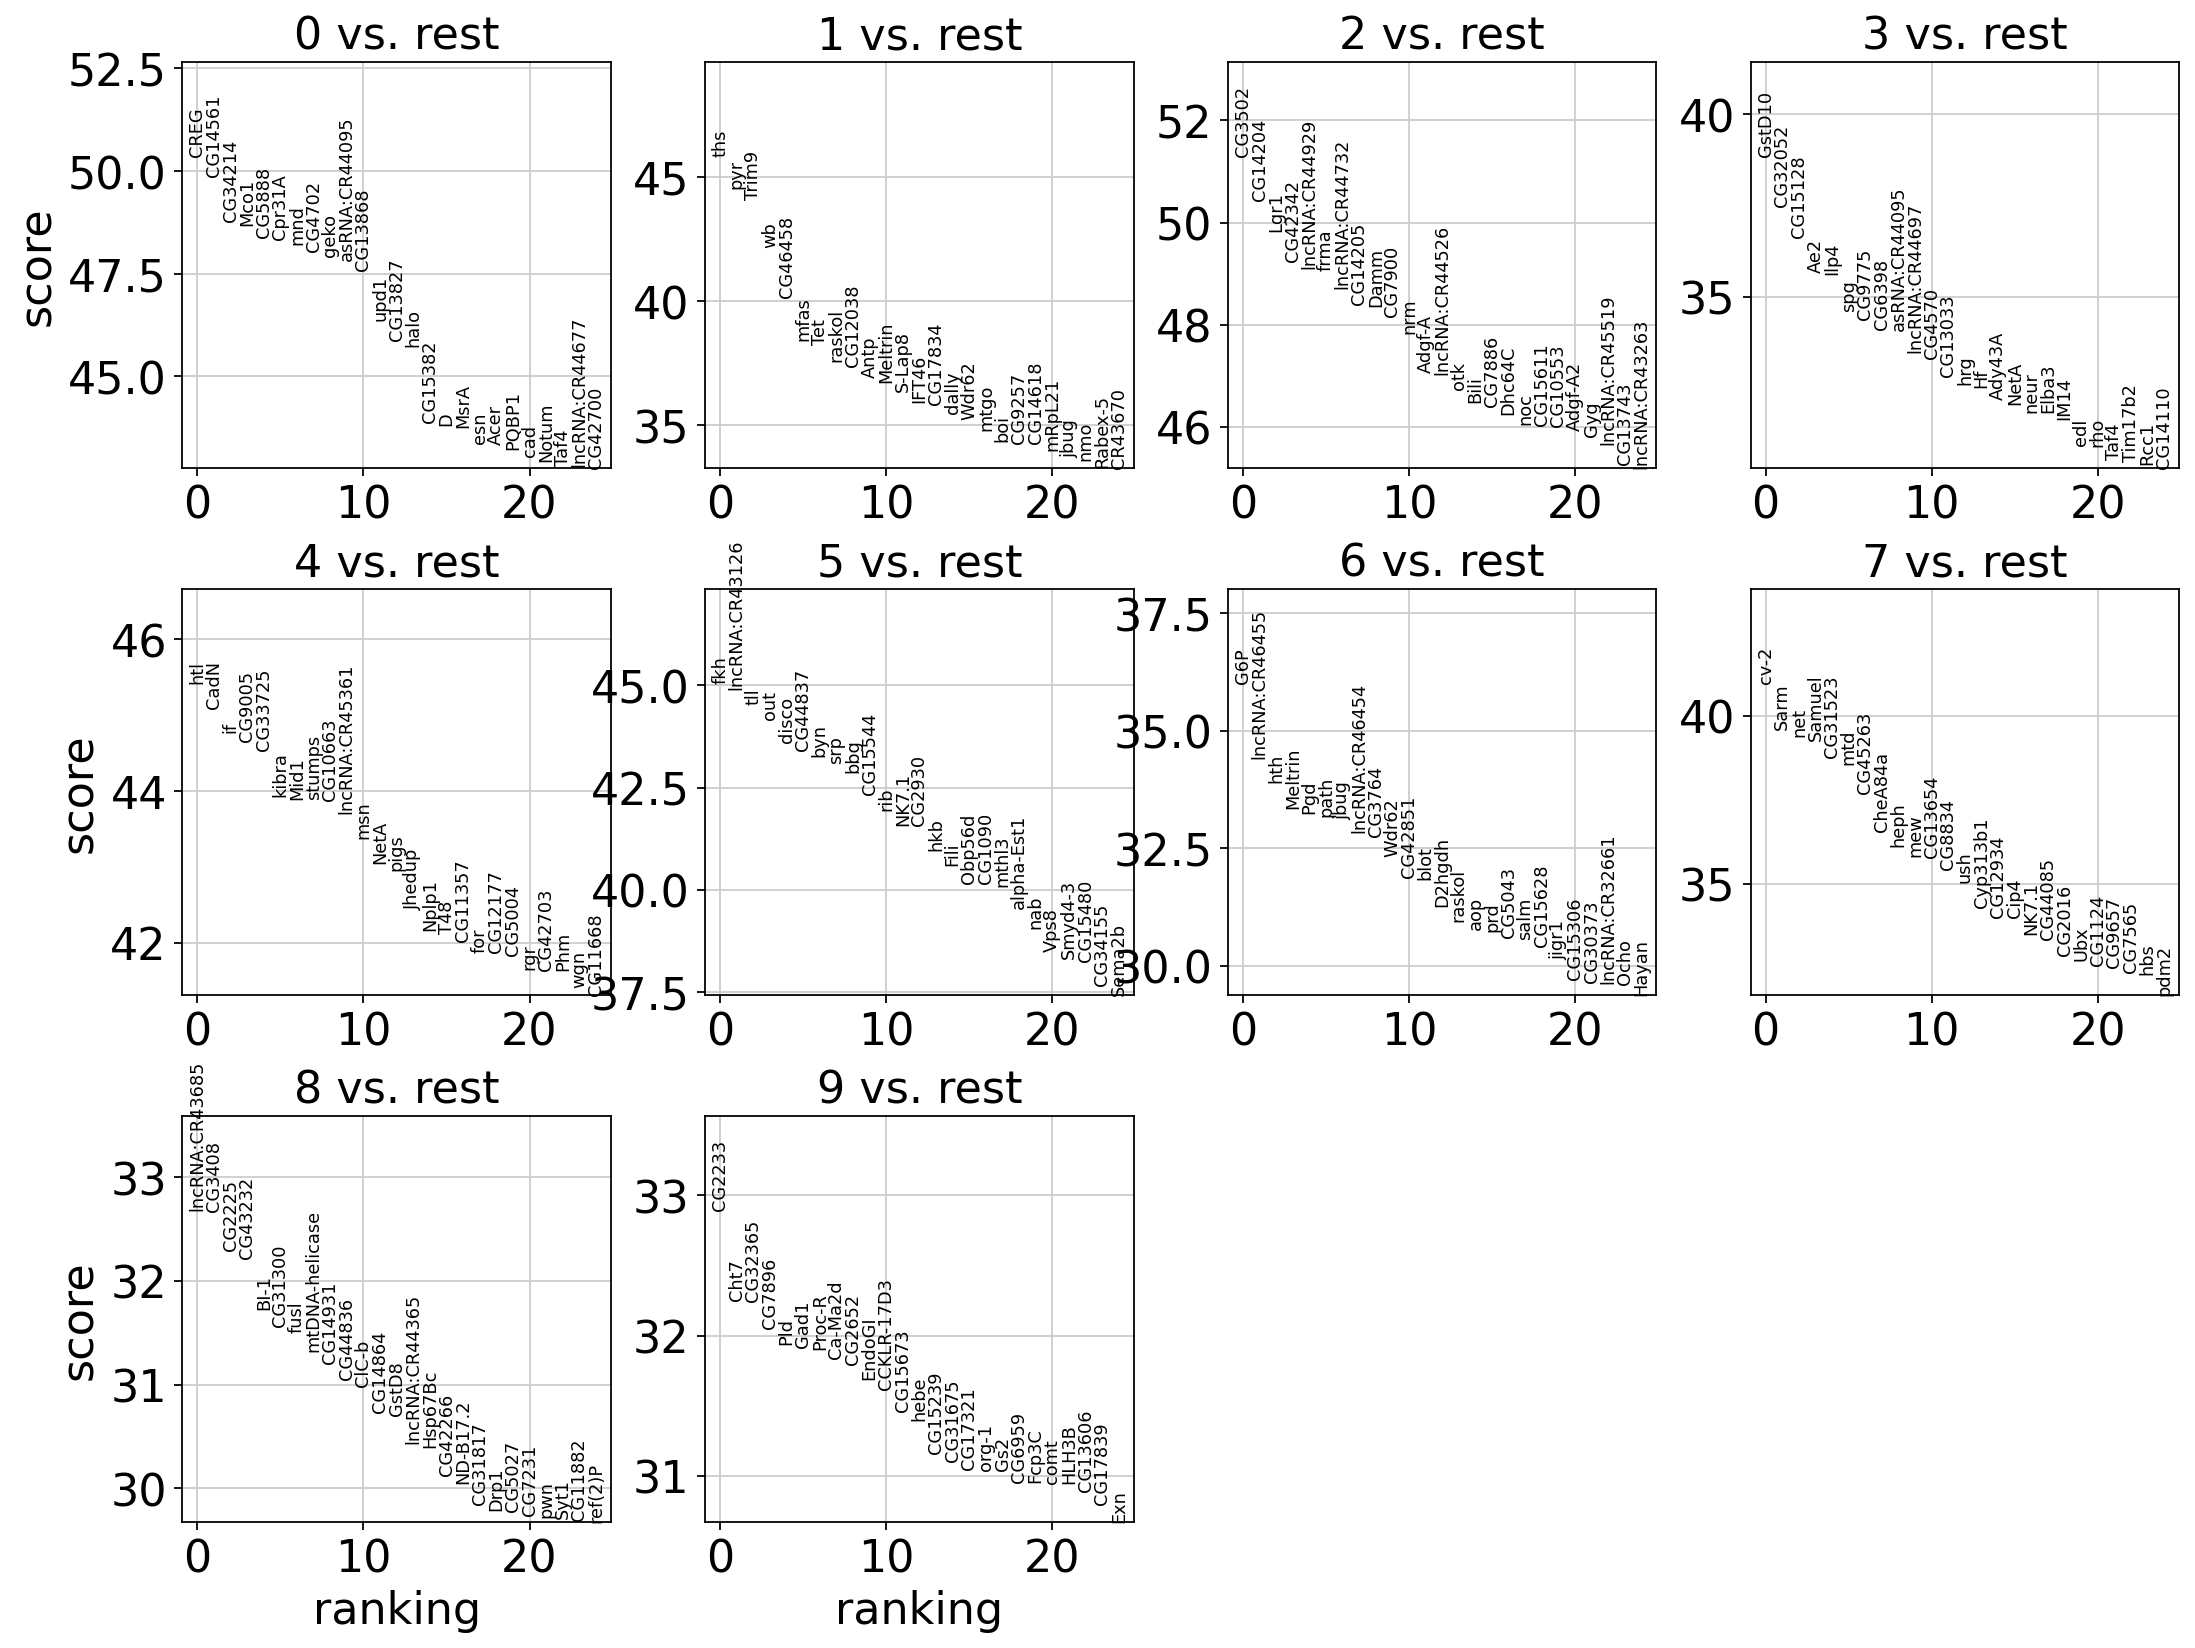

In [61]:
# rank genes for characterizing groups, expects log data
sc.tl.rank_genes_groups(adata, 'leiden_scVI', method='wilcoxon', corr_method="bonferroni", use_raw = False, layer = "norm_log_unscaled")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [62]:
# save top 10 per cluster to csv file
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10).to_csv('top10markers.csv', index = False, sep = '\t')

In [63]:
# hierarchical clustering of clusby leiden
sc.tl.dendrogram(adata, groupby = "leiden_scVI")

In [68]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

0        1  ...               8           9
0            CREG      ths  ...  lncRNA:CR43685      CG2233
1         CG14561      pyr  ...          CG3408        Cht7
2         CG34214    Trim9  ...          CG2225     CG32365
3            Mco1       wb  ...         CG43232      CG7896
4          CG5888  CG46458  ...            BI-1         Pld
5          Cpr31A     mfas  ...         CG31300        Gad1
6             mnd      Tet  ...            fusl      Proc-R
7          CG4702   raskol  ...  mtDNA-helicase     Ca-Ma2d
8            geko  CG12038  ...         CG14931      CG2652
9   asRNA:CR44095     Antp  ...         CG44836      EndoGI
10        CG13868  Meltrin  ...           ClC-b  CCKLR-17D3
11           upd1   S-Lap8  ...         CG14864     CG15673
12        CG13827    IFT46  ...           GstD8        hebe
13           halo  CG17834  ...  lncRNA:CR44365     CG15239
14        CG15382    dally  ...         Hsp67Bc     CG31675
15              D    Wdr62  ...         CG42266     CG17321
16           MsrA     mtgo  ...        ND-B17.2       org-1
17            esn      boi  ...         CG31817         Gs2
18           Acer   CG9257  ...            Drp1      CG6959
19          PQBP1  CG14618  ...          CG5027       Fcp3C

[20 rows x 10 columns]

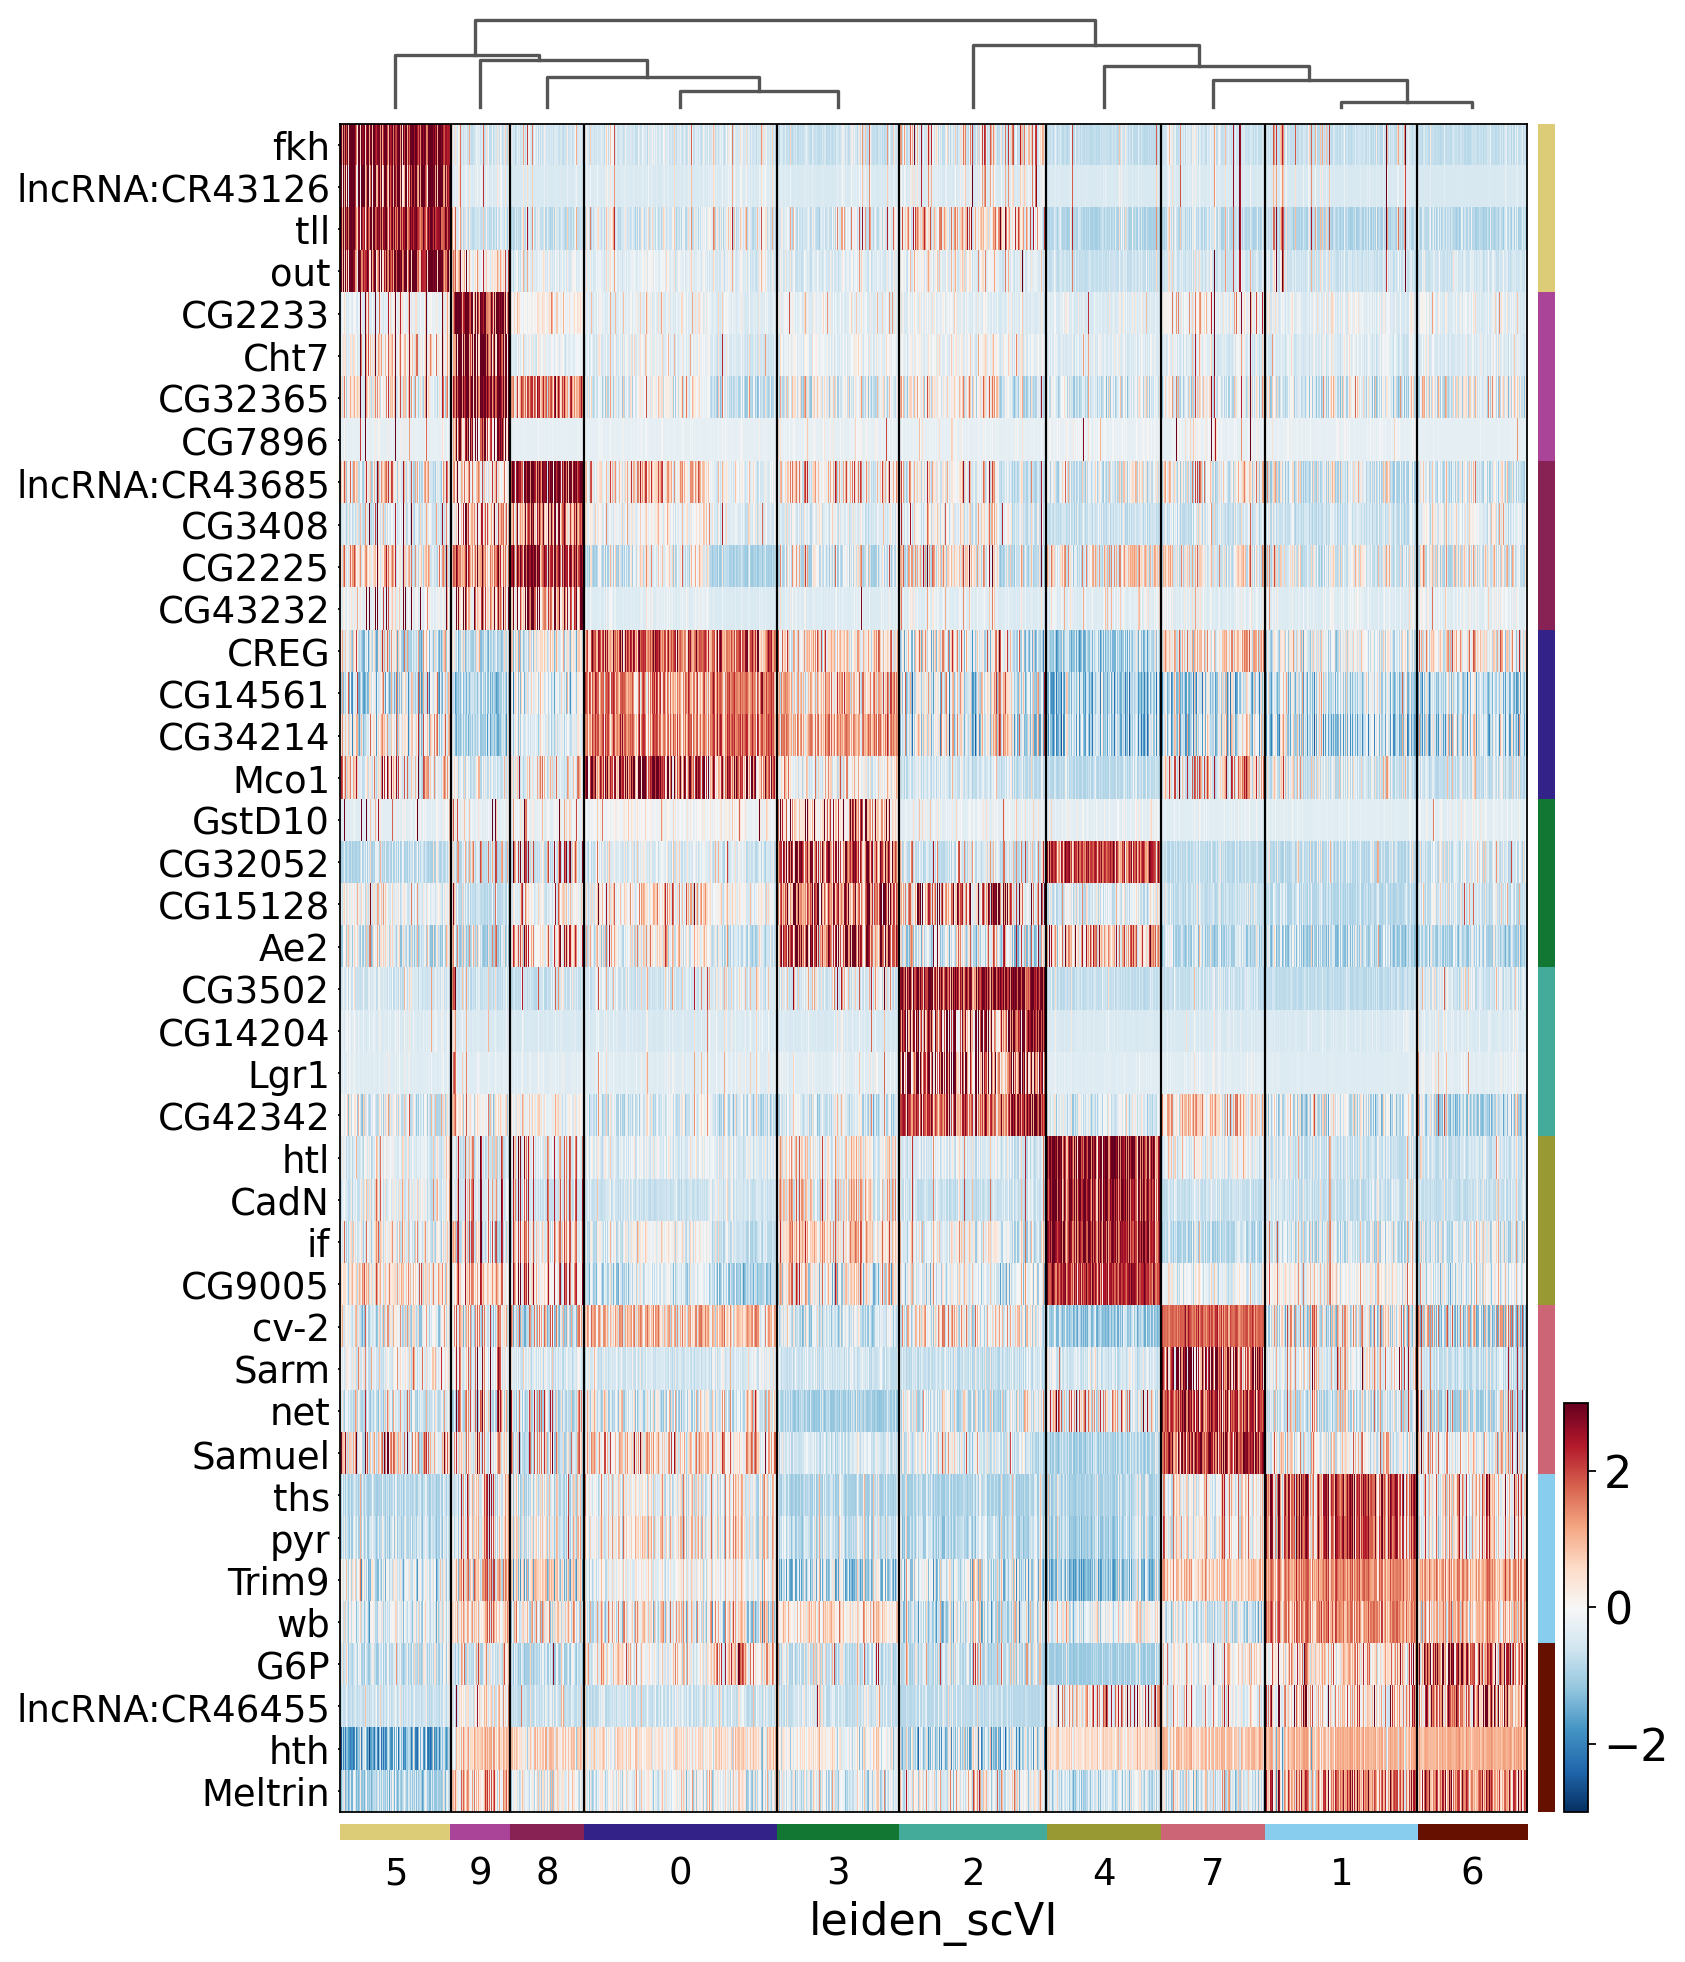

In [64]:
sc.pl.rank_genes_groups_heatmap(adata, 
                                n_genes=4, 
                                use_raw=False, 
                                swap_axes=True, 
                                vmin=-3, vmax=3, 
                                cmap='RdBu_r', 
                                figsize=(10,15),
                                save = 'markergeneheatmap.png')

## Acknowledgements



This notebook is largely inspired by https://github.com/YosefLab/scvi-tools-reproducibility/blob/main/docs/scvi_covariates.ipynb

and https://docs.scvi-tools.org/en/stable/user_guide/notebooks/api_overview.html
